In [20]:
# install required packages
%pip install nltk
%pip install scikit-learn
%pip install tensorflow
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [21]:
# import required packages
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
# download nltk stopwords
nltk.download('stopwords')

# keep all 6 files in the same directory as the ipynb file
# import all files as dictionaries
word_id_to_word = {}
with open('vocabulary.txt', 'r') as f:
    for i, line in enumerate(f):
        word_id_to_word[i + 1] = line.strip()

label_id_to_label = {}
with open('newsgrouplabels.txt', 'r') as f:
    for i, line in enumerate(f):
        label_id_to_label[i + 1] = line.strip()

train_labels = {}
with open('train.label', 'r') as f:
    for i, line in enumerate(f):
        train_labels[i + 1] = int(line.strip())

test_labels = {}
with open('test.label', 'r') as f:
    for i, line in enumerate(f):
        test_labels[i + 1] = int(line.strip())

train_data = {}
with open('train.data', 'r') as f:
    for line in f:
        doc_id, word_id, count = map(int, line.strip().split())
        if doc_id not in train_data:
            train_data[doc_id] = {}
        train_data[doc_id][word_id] = count

test_data = {}
with open('test.data', 'r') as f:
    for line in f:
        doc_id, word_id, count = map(int, line.strip().split())
        if doc_id not in test_data:
            test_data[doc_id] = {}
        test_data[doc_id][word_id] = count


print("Data loaded successfully!")

# Initialize preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_word(word):
    word = word.lower()
    if word in stop_words:
        return None
    return lemmatizer.lemmatize(word, "v")

# loop through all the words in the training and test data and preprocess them, 
# remove them from id mapping if the words are removed by preprocessing
processed_train_data = {}
for doc_id, word_counts in train_data.items():
    processed_train_data[doc_id] = {}
    for word_id, count in word_counts.items():
        original_word = word_id_to_word[word_id]
        processed_word = preprocess_word(original_word)
        if processed_word: # Only add if not a stop word
            if processed_word not in processed_train_data[doc_id]:
                processed_train_data[doc_id][processed_word] = 0
            processed_train_data[doc_id][processed_word] += count

processed_test_data = {}
for doc_id, word_counts in test_data.items():
    processed_test_data[doc_id] = {}
    for word_id, count in word_counts.items():
        original_word = word_id_to_word[word_id]
        processed_word = preprocess_word(original_word)
        if processed_word: # Only add if not a stop word
            if processed_word not in processed_test_data[doc_id]:
                processed_test_data[doc_id][processed_word] = 0
            processed_test_data[doc_id][processed_word] += count

print("Preprocessing completed!")

print(processed_train_data.get(1, None))

print(processed_test_data.get(1, None))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/divyendu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data loaded successfully!
Preprocessing completed!
{'archive': 5, 'name': 2, 'atheism': 10, 'resources': 4, 'alt': 2, 'last': 1, 'modify': 1, 'december': 1, 'version': 3, 'atheist': 9, 'address': 3, 'organizations': 1, 'usa': 4, 'freedom': 2, 'religion': 6, 'foundation': 2, 'darwin': 4, 'fish': 6, 'bumper': 1, 'stickers': 1, 'assort': 3, 'paraphernalia': 1, 'available': 2, 'us': 3, 'write': 12, 'ffrf': 1, 'box': 3, 'madison': 1, 'wi': 1, 'telephone': 4, 'evolution': 3, 'design': 3, 'sell': 2, 'symbol': 1, 'like': 1, 'ones': 1, 'christians': 2, 'stick': 1, 'cars': 1, 'feet': 1, 'word': 1, 'inside': 1, 'deluxe': 1, 'mould': 1, 'plastic': 1, 'postpaid': 1, 'laurel': 1, 'canyon': 1, 'north': 1, 'hollywood': 1, 'ca': 1, 'people': 6, 'san': 1, 'francisco': 1, 'bay': 1, 'area': 2, 'get': 3, 'lynn': 2, 'gold': 1, 'try': 2, 'mail': 4, 'figmo': 1, 'netcom': 1, 'com': 1, 'net': 2, 'go': 2, 'directly': 1, 'price': 1, 'per': 1, 'american': 5, 'press': 8, 'aap': 2, 'publish': 4, 'various': 3, 'book'

In [23]:
# reconstruct documents from word counts, to feed into TF-IDF vectorizer
train_documents = []
for doc_id in sorted(processed_train_data.keys()):
    word_counts = processed_train_data[doc_id]
    document_text = ' '.join([word for word, count in word_counts.items() for _ in range(count)])
    train_documents.append(document_text)

test_documents = []
for doc_id in sorted(processed_test_data.keys()):
    word_counts = processed_test_data[doc_id]
    document_text = ' '.join([word for word, count in word_counts.items() for _ in range(count)])
    test_documents.append(document_text)

In [24]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_documents) # Fit and transform train data
X_test_tfidf = tfidf_vectorizer.transform(test_documents) # Transform test data using fitted vectorizer

y_train = np.array([train_labels[doc_id] for doc_id in sorted(processed_train_data.keys())])
y_test = np.array([test_labels[doc_id] for doc_id in sorted(processed_test_data.keys())])

# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print("\nLogistic Regression Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

print("\nNaive Bayes Model:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


Logistic Regression Model:
Accuracy: 0.8006662225183211
Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.69      0.70       318
           2       0.68      0.77      0.72       389
           3       0.74      0.68      0.71       391
           4       0.70      0.73      0.71       392
           5       0.81      0.79      0.80       383
           6       0.83      0.75      0.79       390
           7       0.73      0.84      0.78       382
           8       0.87      0.87      0.87       395
           9       0.94      0.92      0.93       397
          10       0.88      0.91      0.89       397
          11       0.93      0.95      0.94       399
          12       0.94      0.86      0.90       395
          13       0.68      0.74      0.71       393
          14       0.85      0.85      0.85       393
          15       0.88      0.90      0.89       392
          16       0.76      0.90      0.82       398


In [25]:
# Prepare data for Dual Input CNN using PROCESSED data
max_sequence_length = 0
for doc_id in processed_train_data:
    max_sequence_length = max(max_sequence_length, len(processed_train_data[doc_id]))
for doc_id in processed_test_data:
    max_sequence_length = max(max_sequence_length, len(processed_test_data[doc_id]))
print(f"Maximum sequence length (processed data): {max_sequence_length}")

# Create Tokenizer and vocabulary for PROCESSED words
tokenizer = Tokenizer(oov_token="<unk>") # Initialize tokenizer, add OOV token
processed_documents_for_vocab = []

for doc_id in sorted(processed_train_data.keys()):
    word_counts = processed_train_data[doc_id]
    processed_document_text = ' '.join(word_counts.keys()) # Use processed words as vocabulary source
    processed_documents_for_vocab.append(processed_document_text)
tokenizer.fit_on_texts(processed_documents_for_vocab) # Fit tokenizer on processed words

vocab_size_cnn_word_ids = len(tokenizer.word_index) + 1 # Vocabulary size for PROCESSED word IDs
print(f"Processed vocabulary size: {vocab_size_cnn_word_ids}") # Print vocab size

def prepare_cnn_data(processed_data, max_sequence_length, tokenizer):
    word_ids_data = []
    word_counts_data = []
    for doc_id in sorted(processed_data.keys()):
        doc_word_ids = []
        doc_word_counts = []
        for processed_word, count in processed_data[doc_id].items():
            word_index = tokenizer.word_index.get(processed_word)
            if word_index is not None: # Handle cases where processed_word is not in vocab)
                doc_word_ids.append(word_index)
                doc_word_counts.append(count)
            else:
                doc_word_ids.append(tokenizer.word_index["<unk>"]) # OOV token for word not found

        word_ids_data.append(doc_word_ids)
        word_counts_data.append(doc_word_counts)

    word_ids_padded = pad_sequences(word_ids_data, maxlen=max_sequence_length, padding='post')
    word_counts_padded = pad_sequences(word_counts_data, maxlen=max_sequence_length, padding='post')
    return word_ids_padded, word_counts_padded


X_train_cnn_word_ids, X_train_cnn_word_counts =\
    prepare_cnn_data(processed_train_data, max_sequence_length, tokenizer)
X_test_cnn_word_ids, X_test_cnn_word_counts =\
    prepare_cnn_data(processed_test_data, max_sequence_length, tokenizer)

y_train_cnn = np.array([train_labels[doc_id] for doc_id in sorted(processed_train_data.keys())])
y_test_cnn = np.array([test_labels[doc_id] for doc_id in sorted(processed_test_data.keys())])

Maximum sequence length (processed data): 2265
Processed vocabulary size: 47066


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 494ms/step - accuracy: 0.0565 - loss: 2.9868 - val_accuracy: 0.2804 - val_loss: 2.9135
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 38s 481ms/step - accuracy: 0.4406 - loss: 2.6905 - val_accuracy: 0.5634 - val_loss: 1.8532
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 495ms/step - accuracy: 0.6416 - loss: 1.5409 - val_accuracy: 0.7338 - val_loss: 1.0724
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 499ms/step - accuracy: 0.8448 - loss: 0.7385 - val_accuracy: 0.8163 - val_loss: 0.7257
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 520ms/step - accuracy: 0.9456 - loss: 0.3338 - val_accuracy: 0.8518 - val_loss: 0.5717
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 48s 600ms/step - accuracy: 0.9843 - loss: 0.1455 - val_accuracy: 0.8563 - val_loss: 0.5121
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 49s 607ms/step - accuracy: 0.9940 - loss: 0.0721 - val_accuracy: 0.8580 - val_loss: 0.4792
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 585ms/step - accuracy: 0.9971 - loss: 0.0416 - val_accu

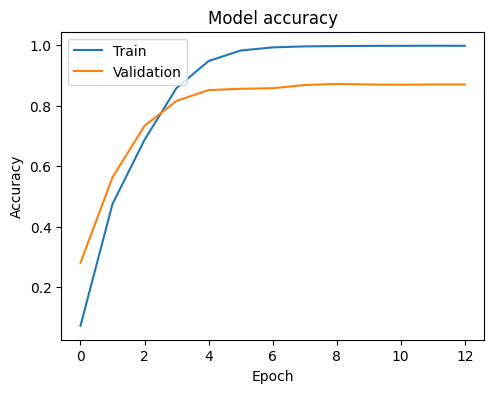

In [26]:

# CNN Model Parameters
embedding_dim_word = 50
embedding_dim_count = 50
num_filters = 128
kernel_size = 5
pool_size = 5
epochs = 20
batch_size = 128
num_classes = len(label_id_to_label)

# Input 1: Processed Word IDs
input_word_ids = Input(shape=(max_sequence_length,), name='word_ids_input')
embedding_word_ids = Embedding(input_dim=vocab_size_cnn_word_ids, output_dim=embedding_dim_word)(input_word_ids)
conv_word_ids = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(embedding_word_ids)
pool_word_ids = MaxPooling1D(pool_size=pool_size)(conv_word_ids)
conv_word_ids = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(pool_word_ids)
output_word_ids = GlobalMaxPooling1D()(pool_word_ids)

# Input 2: Word Counts
input_word_counts = Input(shape=(max_sequence_length,), name='word_counts_input')
embedding_word_counts = Embedding(input_dim=vocab_size_cnn_word_ids, output_dim=embedding_dim_count)(input_word_counts)
conv_word_counts = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(embedding_word_counts)
pool_word_counts = MaxPooling1D(pool_size=pool_size)(conv_word_counts)
conv_word_counts = Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')(pool_word_counts)
output_word_counts = GlobalMaxPooling1D()(pool_word_counts)

# Merge inputs
merged_outputs = Concatenate()([output_word_ids, output_word_counts])

# Final Dense layer
dense_layer = Dense(num_classes, activation='softmax')(merged_outputs)
model_cnn = Model(inputs=[input_word_ids, input_word_counts], outputs=dense_layer)
model_cnn.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=2, # Stop after 2 epochs of no improvement in val_loss
    restore_best_weights=True, # Restore model weights to the epoch with the best val_loss
    verbose=1
)

# stratify split to maintain class distribution
X_train_word_ids, X_val_word_ids, y_train, y_val = train_test_split(
    X_train_cnn_word_ids, y_train_cnn, test_size=0.1, stratify=y_train_cnn
)

X_train_word_counts, X_val_word_counts, _, _ = train_test_split(
    X_train_cnn_word_counts, y_train_cnn, test_size=0.1, stratify=y_train_cnn
)

history_cnn = model_cnn.fit(
    [X_train_word_ids, X_train_word_counts],  # Use the split data
    y_train - 1,  # Subtract 1 for sparse_categorical_crossentropy
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_val_word_ids, X_val_word_counts], y_val - 1),
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate CNN with PROCESSED data
y_pred_cnn_probs =\
    model_cnn.predict([X_test_cnn_word_ids, X_test_cnn_word_counts], verbose=1)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1) + 1

print("\nDual Input CNN Model with Processed Words:")
print("Accuracy:", accuracy_score(y_test_cnn, y_pred_cnn))
print("Classification Report:\n", classification_report(y_test_cnn, y_pred_cnn))

print("Dual Input CNN model with processed words training and evaluation completed.")


# --- Analyze Validation Accuracy ---
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()